<a href="https://colab.research.google.com/github/Tclack88/covid19/blob/master/SEIR_Model_Covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Make sure to open in colab to see the plots!


You might want to change the plot sizes; just ctrl+f for "figsize" and change them all (ex.: (20,4) to (10,2))

# Imports

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline 
!pip install mpld3
import mpld3
mpld3.enable_notebook()

from scipy.integrate import odeint
!pip install lmfit
import lmfit
from lmfit.lineshapes import gaussian, lorentzian

import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 1.0MB 2.7MB/s 
  Created wheel for mpld3: filename=mpld3-0.5.1-cp36-none-any.whl size=364065 sha256=0d2d19cd62912e219bf86d5138cfe71ed4b3452d729dda10b3bc5db9bdad205d
  Stored in directory: /root/.cache/pip/wheels/38/68/06/d119af6c3f9a2d1e123c1f72d276576b457131b3a7bf94e402
Successfully built mpld3
     |████████████████████████████████| 266kB 2.8MB/s 
     |████████████████████████████████| 61kB 6.4MB/s 
     |████████████████████████████████| 256kB 8.7MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.1-cp36-none-any.whl size=81990 sha256=b00af5f457c33ad3d08674b3651fe186d2cab3d2b7d0349c9fe788252e58a7c8
  Stored in directory: /root/.cache/pip/wheels/ef/22/8d/6cd9c0af36f501cfb248673b05dad5d2c27504951d55519acb
  Created wheel for asteval: filename=asteval-0.9.18-cp36-none-any.whl size=17381 sha256=9e758fb328e3f64ca25cf80138fed5b836ae49ee1c651cf3af620bd7eddf8ab3
  Stored in directory: /root/.cache/pip/wheels/1c/53/1b/28d929700c9633b1786a4982e6db564ec

# Curve Fitting Example

We want to fit the following curve:

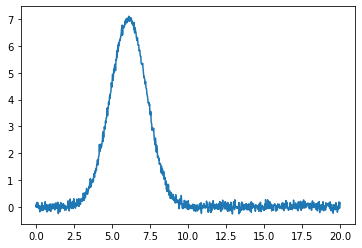

In [2]:
np.random.seed(42)
x = np.linspace(0, 20.0, 1001)

data = (gaussian(x, 21, 6.1, 1.2) + np.random.normal(scale=0.1, size=x.size))  # normal distr. with some noise
plt.plot(x, data);

So we define a function that takes x as the first argument, and then the parameters to be fitted (a, b, c)

In [3]:
def f(x, a, b, c):
    return gaussian(x, a, b, c) 

In [4]:
mod = lmfit.Model(f)
# we set the parameters (and some initial parameter guesses)
mod.set_param_hint("a", value=10.0, vary=True)
mod.set_param_hint("b", value=10.0, vary=True)
mod.set_param_hint("c", value=10.0, vary=True)

params = mod.make_params()

In [5]:
result = mod.fit(data, params, method="leastsq", x=x)  # fitting

{'a': 21.032607052666833, 'b': 6.100343154227002, 'c': 1.200925508808406}

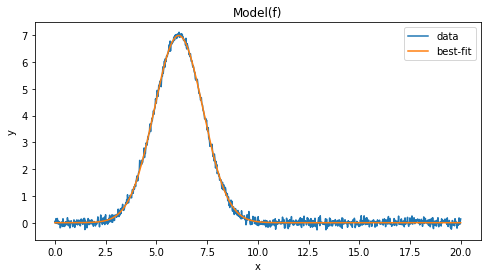

In [6]:
plt.figure(figsize=(8,4))
result.plot_fit(datafmt="-");
result.best_values

In [7]:
result

# Supplemental and Coronavirus Data

In [8]:
# !! if you get a timeout-error, just click on the link and download the data manually !!

# read the data
beds = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/beds.csv", header=0)
agegroups = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/agegroups.csv")
probabilities = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/probabilities.csv")
covid_data = pd.read_csv("https://tinyurl.com/t59cgxn", parse_dates=["Date"], skiprows=[1])
covid_data["Location"] = covid_data["Country/Region"]

# create some dicts for fast lookup
# 1. beds
beds_lookup = dict(zip(beds["Country"], beds["ICU_Beds"]))
# 2. agegroups
agegroup_lookup = dict(zip(agegroups['Location'], agegroups[['0_9', '10_19', '20_29', '30_39', '40_49', '50_59', '60_69', '70_79', '80_89', '90_100']].values))

# store the probabilities collected
prob_I_to_C_1 = list(probabilities.prob_I_to_ICU_1.values)
prob_I_to_C_2 = list(probabilities.prob_I_to_ICU_2.values)
prob_C_to_Death_1 = list(probabilities.prob_ICU_to_Death_1.values)
prob_C_to_Death_2 = list(probabilities.prob_ICU_to_Death_2.values)

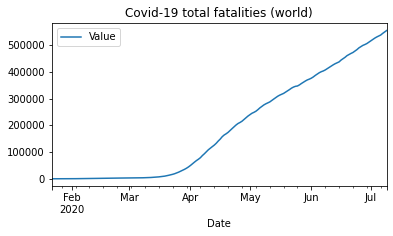

In [9]:
covid_data.groupby("Date").sum()[["Value"]].plot(figsize=(6, 3), title="Covid-19 total fatalities (world)");

## Plotting

In [10]:
plt.gcf().subplots_adjust(bottom=0.15)

def plotter(t, S, E, I, C, R, D, R_0, B, S_1=None, S_2=None, x_ticks=None):
    if S_1 is not None and S_2 is not None:
      print(f"percentage going to ICU: {S_1*100}; percentage dying in ICU: {S_2 * 100}")


    f, ax = plt.subplots(1,1,figsize=(20,4))
    if x_ticks is None:
        ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    else:
        ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(x_ticks, D, 'k', alpha=0.7, linewidth=2, label='Dead')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()


    ax.title.set_text('extended SEIR-Model')

    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();
    
    f = plt.figure(figsize=(20,4))
    # sp1
    ax1 = f.add_subplot(131)
    if x_ticks is None:
        ax1.plot(t, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
    else:
        ax1.plot(x_ticks, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
        ax1.xaxis.set_major_locator(mdates.YearLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

 
    ax1.title.set_text('R_0 over time')
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    
    # sp2
    ax2 = f.add_subplot(132)
    total_CFR = [0] + [100 * D[i] / sum(sigma*E[:i]) if sum(sigma*E[:i])>0 else 0 for i in range(1, len(t))]
    daily_CFR = [0] + [100 * ((D[i]-D[i-1]) / ((R[i]-R[i-1]) + (D[i]-D[i-1]))) if max((R[i]-R[i-1]), (D[i]-D[i-1]))>10 else 0 for i in range(1, len(t))]
    if x_ticks is None:
        ax2.plot(t, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(t, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
    else:
        ax2.plot(x_ticks, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(x_ticks, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
        ax2.xaxis.set_major_locator(mdates.YearLocator())
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax2.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax2.title.set_text('Fatality Rate (%)')
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    # sp3
    ax3 = f.add_subplot(133)
    newDs = [0] + [D[i]-D[i-1] for i in range(1, len(t))]
    if x_ticks is None:
        ax3.plot(t, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(t, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
    else:
        ax3.plot(x_ticks, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(x_ticks, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
        ax3.xaxis.set_major_locator(mdates.YearLocator())
        ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax3.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax3.title.set_text('Deaths per day')
    ax3.yaxis.set_tick_params(length=0)
    ax3.xaxis.set_tick_params(length=0)
    ax3.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax3.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();

<Figure size 432x288 with 0 Axes>

# Model

In [11]:
def deriv(y, t, beta, gamma, sigma, N, p_I_to_C, p_C_to_D, Beds):
    S, E, I, C, R, D = y

    dSdt = -beta(t) * I * S / N 
    dEdt = beta(t) * I * S / N - sigma * E
    dIdt = sigma * E - 1/12.0 * p_I_to_C * I - gamma * (1 - p_I_to_C) * I
    dCdt = 1/12.0 * p_I_to_C * I - 1/7.5 * p_C_to_D * min(Beds(t), C) - max(0, C-Beds(t)) - (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
    dRdt = gamma * (1 - p_I_to_C) * I + (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
    dDdt = 1/7.5 * p_C_to_D * min(Beds(t), C) + max(0, C-Beds(t))
    return dSdt, dEdt, dIdt, dCdt, dRdt, dDdt

In [12]:
gamma = 1.0/9.0
sigma = 1.0/3.0



def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):

    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma

    # def beta(t):
    #     return logistic_R_0(t, R_0_start, k, x0, R_0_end) / (( 1 - prob_I_to_C) / gamma + prob_I_to_C / (1/12.0))

    N = sum(agegroups)
    
    def Beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003

    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    ret = odeint(deriv, y0, t, args=(beta, gamma, sigma, N, prob_I_to_C, prob_C_to_D, Beds))
    S, E, I, C, R, D = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]

    return t, S, E, I, C, R, D, R_0_over_time, Beds, prob_I_to_C, prob_C_to_D

percentage going to ICU: 5.0; percentage dying in ICU: 60.0


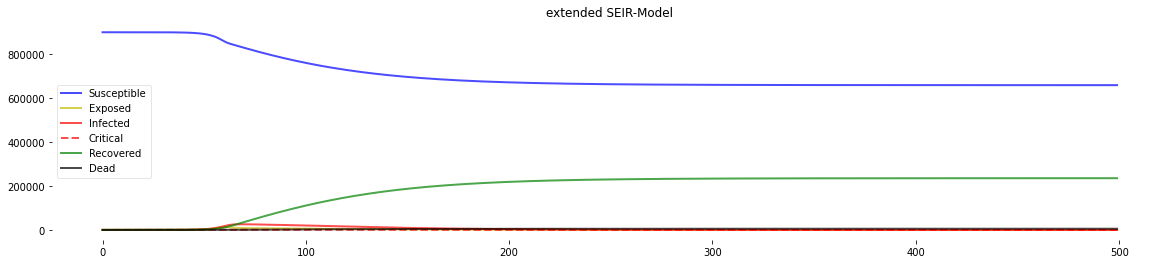

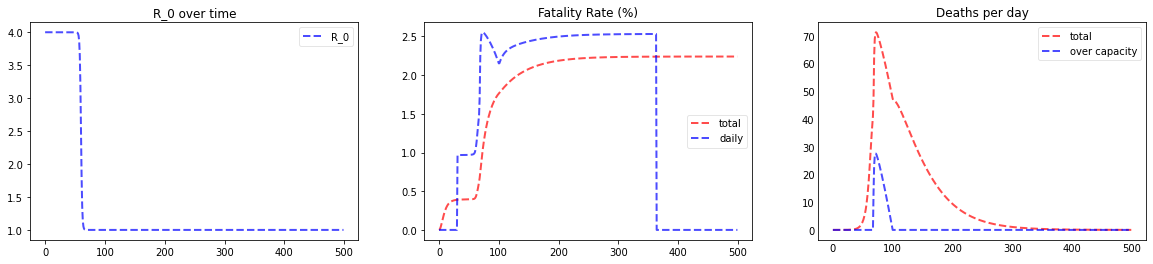

In [13]:
plotter(*Model(days=500, agegroups=[100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000], 
               beds_per_100k=50, R_0_start=4.0, k=1.0, x0=60, R_0_end=1.0, 
               prob_I_to_C=0.05, prob_C_to_D=0.6, s=0.003))

# Fitting

In [14]:
covid_data[covid_data["Location"] == "United Kingdom"].Date.value_counts()

2020-06-14    11
2020-03-01    11
2020-03-23    11
2020-02-07    11
2020-06-10    11
              ..
2020-05-15    11
2020-03-31    11
2020-02-15    11
2020-06-18    11
2020-02-11    11
Name: Date, Length: 170, dtype: int64

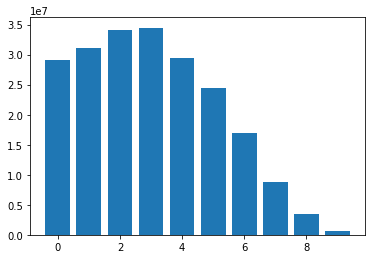

In [15]:
size = len(agegroup_lookup['Brazil'])
plt.bar(range(size),agegroup_lookup['Brazil']);

In [16]:

beds_lookup['Brazil'] = 4.1  # beds from: http://outbreaknewstoday.com/brazil-covid-19-cases-top-800k-8575-icu-beds-enabled-16142/, population from google search
# this is 8,675 / 209.5 mill = 8675/2095 hundred thousand
# beds_lookup # potentiall old: https://link.springer.com/article/10.1007/s00134-012-2627-8

In [17]:
covid_data[covid_data["Location"] == "United Kingdom"]["Province/State"].unique()
# covid_data.columns

array([nan, 'Anguilla', 'Bermuda', 'British Virgin Islands',
       'Cayman Islands', 'Channel Islands', 'Falkland Islands (Malvinas)',
       'Gibraltar', 'Isle of Man', 'Montserrat',
       'Turks and Caicos Islands'], dtype=object)

In [18]:
# parameters
data = covid_data[covid_data["Location"] == "United Kingdom"]["Value"].values[::-1]
agegroups = agegroup_lookup["United Kingdom"]
beds_per_100k = beds_lookup["United Kingdom"]
outbreak_shift = 0
params_init_min_max = {"R_0_start": (3.0, 2.0, 5.0), "k": (2.5, 0.01, 5.0), "x0": (90, 0, 120), "R_0_end": (0.9, 0.3, 3.5),
                       "prob_I_to_C": (0.05, 0.01, 0.1), "prob_C_to_D": (0.5, 0.05, 0.8),
                       "s": (0.003, 0.001, 0.01)}  # form: {parameter: (initial guess, minimum value, max value)}

In [19]:
days = outbreak_shift + len(data)
if outbreak_shift >= 0:
    y_data = np.concatenate((np.zeros(outbreak_shift), data))
else:
    y_data = y_data[-outbreak_shift:]

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array

def fitter(x, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):
    ret = Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s)
    return ret[6][x]

In [20]:
mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"


In [21]:
result = mod.fit(y_data, params, method=fit_method, x=x_data)

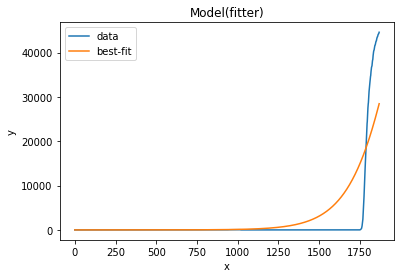

In [22]:
result.plot_fit(datafmt="-");

In [23]:
result.best_values

{'R_0_end': 1.0739412332697387,
 'R_0_start': 2.416141972257252,
 'k': 2.6557367377422088,
 'prob_C_to_D': 0.5224035930903659,
 'prob_I_to_C': 0.031038786052653658,
 's': 0.003,
 'x0': 0.9344445832692694}

Prediction for US
percentage going to ICU: 3.1038786052653657; percentage dying in ICU: 52.24035930903659


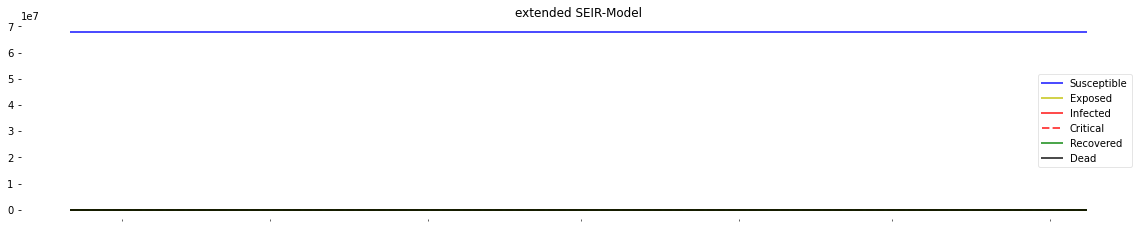

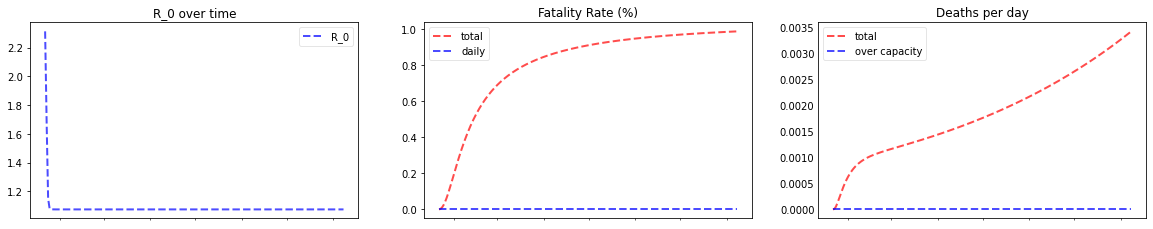

In [24]:
full_days = 200
first_date = np.datetime64(covid_data.Date.min()) - np.timedelta64(outbreak_shift,'D')
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
print("Prediction for US")
plotter(*Model(full_days, agegroup_lookup["United Kingdom"], beds_lookup["United Kingdom"], **result.best_values), x_ticks=x_ticks);

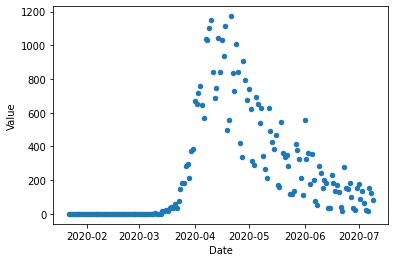

In [25]:
#plot current deaths per day to confirm:
tmp_dat = covid_data[covid_data["Location"] == "United Kingdom"][['Date','Value']]
tmp_dat = covid_data[covid_data["ISO 3166-1 Alpha 3-Codes"] == "GBR"][['Date','Value']] # UK only
tmp_dat.Date = pd.to_datetime(tmp_dat.Date)
tmp_dat.Value = tmp_dat.Value.diff(periods=-1).fillna(0)
tmp_dat.plot.scatter('Date', 'Value');

# Vaccine mode

### Important! 
Run this parameteres each time the country is changed

In [26]:
# parameters
data = covid_data[covid_data["Location"] == "Brazil"]["Value"].values[::-1]
# data = covid_data[covid_data["ISO 3166-1 Alpha 3-Codes"] == "GBR"]['Value'].values[::-1] #for UK only (courtesy of the British Empire)

agegroups = agegroup_lookup["Brazil"]
beds_per_100k = beds_lookup["Brazil"]
outbreak_shift = 0
params_init_min_max = {"R_0_start": (3.0, 2.0, 5.0), "k": (2.5, 0.01, 5.0), "x0": (90, 0, 120), "R_0_end": (0.9, 0.3, 3.5),
                       "prob_I_to_C": (0.05, 0.01, 0.1), "prob_C_to_D": (0.5, 0.05, 0.8),
                       "s": (0.003, 0.001, 0.01)}  # form: {parameter: (initial guess, minimum value, max value)}

In [27]:
def vac_deriv(y, t, beta, gamma, sigma, N, p_I_to_C, p_C_to_D, Beds):
    S, E, I, C, R, D = y
    if t > 100: # After 100 days (arbitrary choice)
        frac = .05 # fraction of susceptible people who take vaccine each day
        dSdt = -beta(t) * I * S / N - frac*S
        dRdt = gamma * (1 - p_I_to_C) * I + (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C) + frac*S
    else:  
        dSdt = -beta(t) * I * S / N 
        dRdt = gamma * (1 - p_I_to_C) * I + (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)

    dEdt = beta(t) * I * S / N - sigma * E
    dIdt = sigma * E - 1/12.0 * p_I_to_C * I - gamma * (1 - p_I_to_C) * I
    dCdt = 1/12.0 * p_I_to_C * I - 1/7.5 * p_C_to_D * min(Beds(t), C) - max(0, C-Beds(t)) - (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
    dDdt = 1/7.5 * p_C_to_D * min(Beds(t), C) + max(0, C-Beds(t))
    return dSdt, dEdt, dIdt, dCdt, dRdt, dDdt

def vac_Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):

    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma

    # def beta(t):
    #     return logistic_R_0(t, R_0_start, k, x0, R_0_end) / (( 1 - prob_I_to_C) / gamma + prob_I_to_C / (1/12.0))

    N = sum(agegroups)
    
    def Beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003

    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    ret = odeint(vac_deriv, y0, t, args=(beta, gamma, sigma, N, prob_I_to_C, prob_C_to_D, Beds))
    S, E, I, C, R, D = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]

    return t, S, E, I, C, R, D, R_0_over_time, Beds, prob_I_to_C, prob_C_to_D

In [28]:
plt.gcf().subplots_adjust(bottom=0.15)

def vac_plotter(t, S, E, I, C, R, D, R_0, B, S_1=None, S_2=None, x_ticks=None):
    if S_1 is not None and S_2 is not None:
      print(f"percentage going to ICU: {S_1*100}; percentage dying in ICU: {S_2 * 100}")


    f, ax = plt.subplots(1,1,figsize=(20,4))
    if x_ticks is None:
        ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    else:
        ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(x_ticks, D, 'k', alpha=0.7, linewidth=2, label='Dead')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()


    ax.title.set_text('extended SEIR-Model')

    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();
    
    f = plt.figure(figsize=(20,4))
    # sp1
    ax1 = f.add_subplot(131)
    if x_ticks is None:
        ax1.plot(t, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
    else:
        ax1.plot(x_ticks, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
        ax1.xaxis.set_major_locator(mdates.YearLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

 
    ax1.title.set_text('R_0 over time')
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    
    # sp2
    ax2 = f.add_subplot(132)
    total_CFR = [0] + [100 * D[i] / sum(sigma*E[:i]) if sum(sigma*E[:i])>0 else 0 for i in range(1, len(t))]
    daily_CFR = [0] + [100 * ((D[i]-D[i-1]) / ((R[i]-R[i-1]) + (D[i]-D[i-1]))) if max((R[i]-R[i-1]), (D[i]-D[i-1]))>10 else 0 for i in range(1, len(t))]
    if x_ticks is None:
        ax2.plot(t, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(t, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
    else:
        ax2.plot(x_ticks, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(x_ticks, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
        ax2.xaxis.set_major_locator(mdates.YearLocator())
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax2.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax2.title.set_text('Fatality Rate (%)')
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    # sp3
    ax3 = f.add_subplot(133)
    newDs = [0] + [D[i]-D[i-1] for i in range(1, len(t))]
    if x_ticks is None:
        ax3.plot(t, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(t, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
    else:
        ax3.plot(x_ticks, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(x_ticks, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
        ax3.xaxis.set_major_locator(mdates.YearLocator())
        ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax3.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax3.title.set_text('Deaths per day')
    ax3.yaxis.set_tick_params(length=0)
    ax3.xaxis.set_tick_params(length=0)
    ax3.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax3.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();

<Figure size 432x288 with 0 Axes>

### Important
Change country here as well

Prediction for US
percentage going to ICU: 1.9896144080468838; percentage dying in ICU: 24.68537933749041


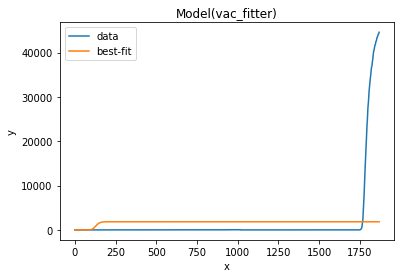

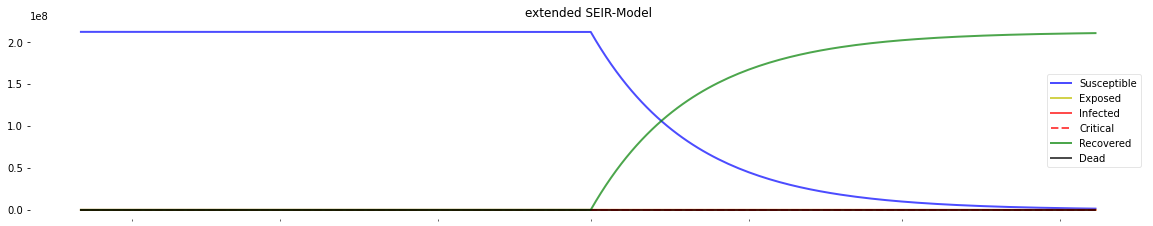

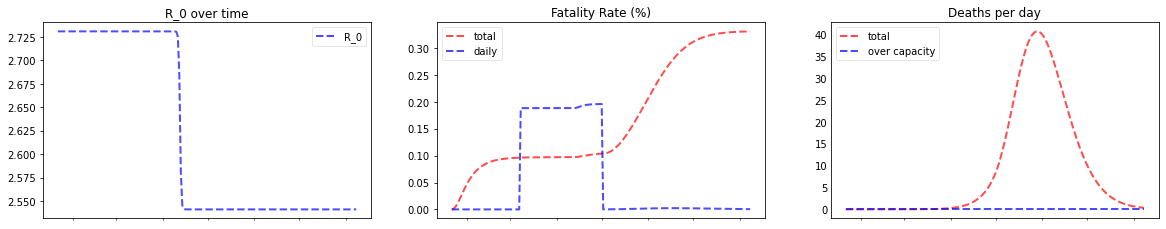

In [29]:
def vac_fitter(x, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):
    ret = vac_Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s)
    return ret[6][x]

vac_mod = lmfit.Model(vac_fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    vac_mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = vac_mod.make_params()
fit_method = "leastsq"


vac_result = vac_mod.fit(y_data, params, method=fit_method, x=x_data)

vac_result.plot_fit(datafmt="-");

full_days = 200
first_date = np.datetime64(covid_data.Date.min()) - np.timedelta64(outbreak_shift,'D')
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
print("Prediction for US")
vac_plotter(*vac_Model(full_days, agegroup_lookup["Brazil"], beds_lookup["Brazil"], **vac_result.best_values), x_ticks=x_ticks);

# Mutation Model

### Important
If changing the countries, re-run here

In [30]:
# parameters
country = "Brazil"
alt_name = "Brazil" #(Usually the same except US instead of "United States")
data = covid_data[covid_data["Location"] == country]["Value"].values[::-1]
# data = covid_data[covid_data["ISO 3166-1 Alpha 3-Codes"] == "GBR"]['Value'].values[::-1] #for UK only (courtesy of the British Empire)

agegroups = agegroup_lookup[alt_name] # US instead of United States, here if applicable
beds_per_100k = beds_lookup[country]
outbreak_shift = 0
params_init_min_max = {"R_0_start": (3.0, 2.0, 5.0), "k": (2.5, 0.01, 5.0), "x0": (90, 0, 120), "R_0_end": (0.9, 0.3, 3.5),
                       "prob_I_to_C": (0.05, 0.01, 0.1), "prob_C_to_D": (0.5, 0.05, 0.8),
                       "s": (0.003, 0.001, 0.01)}  # form: {parameter: (initial guess, minimum value, max value)}

In [31]:
FLAG = True

def mut_deriv(y, t, beta, gamma, sigma, N, p_I_to_C, p_C_to_D, Beds):  #If  no change from original deriv in the end, consider removing
    S, E, I, C, R, D = y
    global FLAG
    mutation_date = 150
    if t > mutation_date and FLAG: # After 150 days (arbitrary choice)
        frac = .99 # fraction of recovered individuals who are moved back to susceptible
        dSdt = -beta(t) * I * S / N + frac*R
        dRdt = gamma * (1 - p_I_to_C) * I + (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C) - frac*R
        FLAG = False
    else:  
        dSdt = -beta(t) * I * S / N 
        dRdt = gamma * (1 - p_I_to_C) * I + (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
    dEdt = beta(t) * I * S / N - sigma * E
    dIdt = sigma * E - 1/12.0 * p_I_to_C * I - gamma * (1 - p_I_to_C) * I
    dCdt = 1/12.0 * p_I_to_C * I - 1/7.5 * p_C_to_D * min(Beds(t), C) - max(0, C-Beds(t)) - (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
    dDdt = 1/7.5 * p_C_to_D * min(Beds(t), C) + max(0, C-Beds(t))

      
    return dSdt, dEdt, dIdt, dCdt, dRdt, dDdt


def mut_Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):

    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma

    # def beta(t):
    #     return logistic_R_0(t, R_0_start, k, x0, R_0_end) / (( 1 - prob_I_to_C) / gamma + prob_I_to_C / (1/12.0))

    N = sum(agegroups)
    
    def Beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003

    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    ret = odeint(mut_deriv, y0, t, args=(beta, gamma, sigma, N, prob_I_to_C, prob_C_to_D, Beds))
    S, E, I, C, R, D = ret.T

    R_0_over_time = [beta(i)/gamma for i in range(len(t))]

    return t, S, E, I, C, R, D, R_0_over_time, Beds, prob_I_to_C, prob_C_to_D

Prediction for Brazil
percentage going to ICU: 1.3964810263021823; percentage dying in ICU: 38.966149054156304


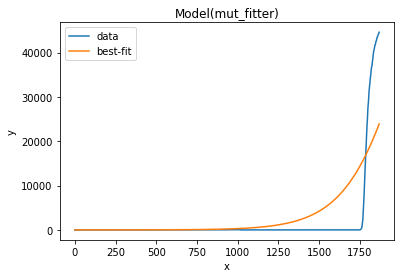

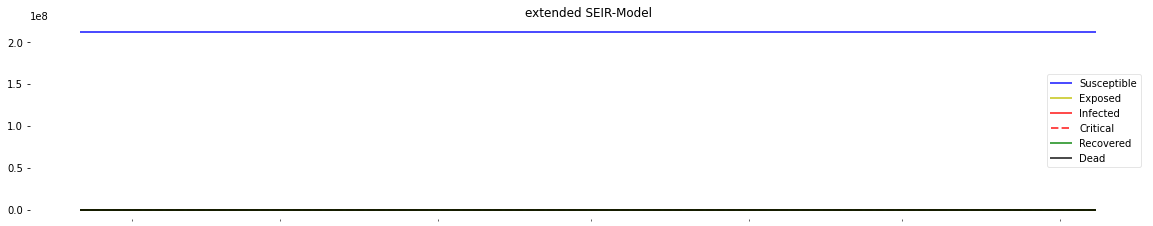

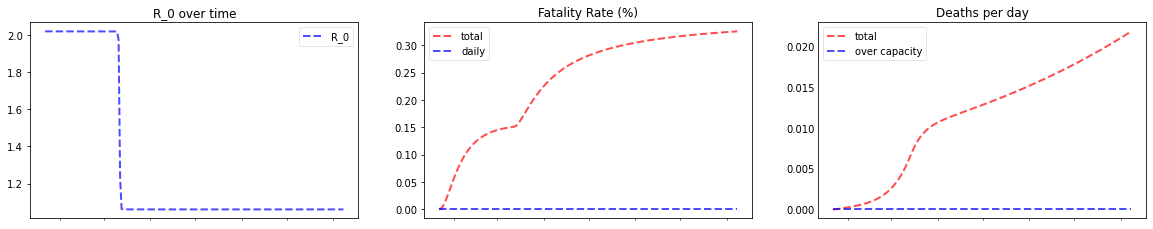

In [39]:
def mut_fitter(x, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):
    ret = mut_Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s)
    return ret[6][x]

mut_mod = lmfit.Model(mut_fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mut_mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mut_mod.make_params()
fit_method = "least_squares"


mut_result = mut_mod.fit(y_data, params, method=fit_method, x=x_data)

mut_result.plot_fit(datafmt="-");

full_days = 200
first_date = np.datetime64(covid_data.Date.min()) - np.timedelta64(outbreak_shift,'D')
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
print(f"Prediction for {country}")
plotter(*mut_Model(full_days, agegroups, beds_per_100k, **mut_result.best_values), x_ticks=x_ticks);

-Add confidence interval to plot

-Compare death rate (per capita) of black people US vs UK -US,UK,Brazil --disproportionate death rates compared to population ratio (in theory should be the same)

-mutation  -- model with changing dS/dt (remove R alltogether https://youtu.be/f1a8JYAixXU?t=601)

-Vaccine   -- model with changing dS/dt  (subtract from S add to R https://youtu.be/f1a8JYAixXU?t=513)



# Racial/Ethnic Plots

In [33]:
import pandas as pd

### US

In [40]:
# US deaths from Covid
us_dat = "https://docs.google.com/spreadsheets/d/e/2PACX-1vR_xmYt4ACPDZCDJcY12kCiMiH0ODyx3E1ZvgOHB8ae1tRcjXbs_yWBOA4j4uoCEADVfC1PS2jYO68B/pub?gid=43720681&single=true&output=csv"
us_covid_df = pd.read_csv(us_dat)
us_covid_df = us_covid_df[['Deaths_Total','Deaths_White',
       'Deaths_Black', 'Deaths_LatinX', 'Deaths_Asian', 'Deaths_AIAN',
       'Deaths_NHPI', 'Deaths_Multiracial', 'Deaths_Other', 'Deaths_Unknown',
       'Deaths_Ethnicity_Hispanic', 'Deaths_Ethnicity_NonHispanic',
       'Deaths_Ethnicity_Unknown']].fillna(0)

us_covid_df = pd.DataFrame(us_covid_df.sum()).T
us_covid_df = round(us_covid_df / us_covid_df.Deaths_Total[0] * 100,2).drop(columns = ['Deaths_Total'])
us_covid_df = us_covid_df.T.reset_index()
us_covid_df.columns = ['ethnicity', 'percent']
us_covid_df = us_covid_df.loc[[0,1,9,3,6]] # double check later to confirm distribution - adds up to 88 percent
us_covid_df.percent = us_covid_df.percent.apply(lambda x: round(100 * x/us_covid_df.percent.sum(),1))
us_covid_df.ethnicity = ['white','black','hispanic','asian','mixed']
us_covid_df = us_covid_df.reset_index()[['ethnicity','percent']]
us_covid_df

,ethnicity,percent
0,white,54.4
1,black,24.0
2,hispanic,16.9
3,asian,4.4
4,mixed,0.2


In [41]:
# US Ethnicity distribution
us_census_dat = "https://www.census.gov/quickfacts/fact/table/US/PST045219"
us_census_df = pd.read_html(us_census_dat)
us_census_df = us_census_df[1].iloc[10:18]
us_census_df.columns = ['ethnicity', 'percent']
us_census_df.percent = us_census_df.percent.apply(lambda x: float(''.join(list(x)[2:-1])))
us_census_df = us_census_df.loc[[17,11,16,13,15]]# double check later to confirm distribution
us_census_df.percent = us_census_df.percent.apply(lambda x: round(100 * x/us_census_df.percent.sum(),1)) # normalize (from nearly 100)
us_census_df.ethnicity = ['white','black','hispanic','asian','mixed']
us_census_df = us_census_df.reset_index()[['ethnicity','percent']]
us_census_df

,ethnicity,percent
0,white,59.7
1,black,13.3
2,hispanic,18.4
3,asian,5.9
4,mixed,2.8


In [42]:
from scipy.stats import ttest_ind
ttest_ind(us_census_df.percent,us_covid_df.percent)

Ttest_indResult(statistic=0.002841759252802323, pvalue=0.99780219228613)

In [217]:
us_df = us_census_df.merge(us_covid_df,on="ethnicity").set_index('ethnicity')
us_df.columns = ['population frequency','killed by Covid']
us_df

,population frequency,killed by Covid
ethnicity,,
white,59.7,54.4
black,13.3,24.0
hispanic,18.4,16.9
asian,5.9,4.4
mixed,2.8,0.2


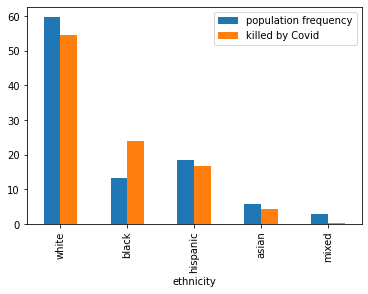

In [218]:
us_df.plot(kind='bar',);

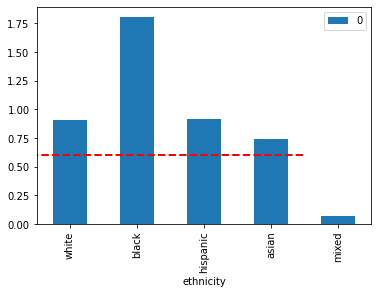

In [238]:
# normalized, in a "fair world" these would all be close to about 1
temp_us_df = us_df['killed by Covid']/us_df['population frequency']
us_plot = pd.DataFrame(temp_us_df).plot(kind='bar')
us_plot.axhline(y=.6, xmin=-.15, xmax=.8, color='r', linestyle='--', lw=2);

### UK

In [139]:
#COVID
!wget "https://www.ons.gov.uk/download/table?format=csv&uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/articles/coronavirusrelateddeathsbyethnicgroupenglandandwales/2march2020to10april2020/60e18f0f.json" -O uk_covid_dat

--2020-07-10 16:28:22--  https://www.ons.gov.uk/download/table?format=csv&uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/articles/coronavirusrelateddeathsbyethnicgroupenglandandwales/2march2020to10april2020/60e18f0f.json
Resolving www.ons.gov.uk (www.ons.gov.uk)... 104.20.32.77, 104.20.31.77, 172.67.34.168, ...
Connecting to www.ons.gov.uk (www.ons.gov.uk)|104.20.32.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 512 [text/csv]
Saving to: ‘uk_covid_dat’

uk_covid_dat        100%[===================>]     512  --.-KB/s    in 0s      

2020-07-10 16:28:22 (102 MB/s) - ‘uk_covid_dat’ saved [512/512]



In [201]:
uk_covid_df = pd.read_csv("./uk_covid_dat",skiprows=4).dropna().loc[:5].drop(columns=['Unnamed: 0','Total'])
uk_covid_df.White = uk_covid_df.White.apply(lambda x: int(x.replace(',','')))
uk_covid_df = pd.DataFrame(uk_covid_df.sum())
uk_covid_df.columns = ['percent']
uk_covid_df = uk_covid_df.percent.apply(lambda x: round(100 * x / uk_covid_df.percent.sum(),1)).reset_index()
uk_covid_df.columns = ['ethnicity','percent']
uk_covid_df.ethnicity = ['white','mixed','indian','bangladeshi_and_pakistani','chinese','black','other']
uk_covid_df

,ethnicity,percent
0,white,83.8
1,mixed,0.7
2,indian,3.8
3,bangladeshi_and_pakistani,3.0
4,chinese,0.5
5,black,6.0
6,other,2.3


In [209]:
# Demographics
# source: https://www.ethnicity-facts-figures.service.gov.uk/uk-population-by-ethnicity/national-and-regional-populations/population-of-england-and-wales/latest
uk_census_dat = "https://www.ethnicity-facts-figures.service.gov.uk/uk-population-by-ethnicity/national-and-regional-populations/population-of-england-and-wales/latest/downloads/by-ethnicity.csv"
uk_census_df = pd.read_csv(uk_census_dat)
uk_census_df = uk_census_df.set_index('Ethnicity')
uk_census_df.Number = uk_census_df.Number.apply(lambda x: int(x.replace(',','')))
# uk_census_df = uk_census_df[['Ethnicity','%']]
uk_census_df.columns = ['number','percent']
uk_census_df = uk_census_df.T
# To match census data groupings: "Asian other" combined to Other, Bangladeshi and Pakistani combined. White combined, Black combined, mixed combined
uk_census_df.Bangladeshi = uk_census_df[['Bangladeshi', 'Pakistani']].sum(axis=1)
uk_census_df.Other =  uk_census_df[['Other', 'Asian other']].sum(axis=1)
uk_census_df = uk_census_df.drop(columns=['Black African', 'Black Caribbean', 'Black other','Mixed White/Asian',
       'Mixed White/Black African', 'Mixed White/Black Caribbean', 'Mixed other', 'Asian', 'Asian other','Pakistani',
       'White British', 'White Irish','White Gypsy/Traveller', 'White other', 'Arab','Any other','All']) 
uk_census_df.columns= ["bangladeshi_and_pakistani",'chinese','indian','black','mixed','white','other']
uk_census_df = uk_census_df.T.reset_index().drop(columns=['number'])
uk_census_df.columns = ['ethnicity','percent']
uk_census_df

,ethnicity,percent
0,bangladeshi_and_pakistani,2.8
1,chinese,0.7
2,indian,2.5
3,black,3.3
4,mixed,2.2
5,white,86.0
6,other,2.5


In [214]:
uk_df = uk_census_df.merge(uk_covid_df,on='ethnicity').set_index('ethnicity')
uk_df.columns = ['population frequency','killed by Covid']
uk_df

,population frequency,killed by Covid
ethnicity,,
bangladeshi_and_pakistani,2.8,3.0
chinese,0.7,0.5
indian,2.5,3.8
black,3.3,6.0
mixed,2.2,0.7
white,86.0,83.8
other,2.5,2.3


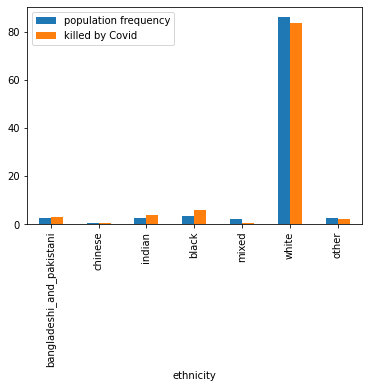

In [215]:
uk_df.plot(kind='bar',);

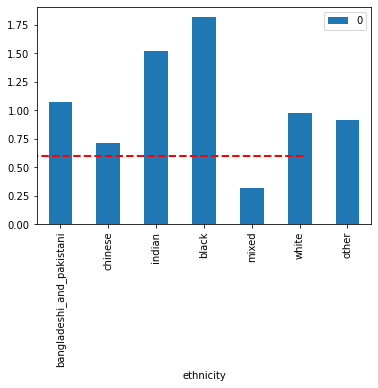

In [237]:
# normalized, in a "fair world" these would all be close to about 1
temp_uk_df = uk_df['killed by Covid']/uk_df['population frequency']
uk_plot = pd.DataFrame(temp_uk_df).plot(kind='bar')
uk_plot.axhline(y=.6, xmin=-.15, xmax=.8, color='r', linestyle='--', lw=2);

https://www.nature.com/articles/s41586-020-2521-4_reference.pdf?referringSource=articleShare 

https://github.com/opensafely/risk-factors-research


- high blood pressure
- cancer
- lung disease
- diabetes